In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import tweepy
import json
import pandas as pd
import csv
import re
from textblob import TextBlob
import string
import preprocessor as p
import os
import time

In [6]:
import numpy as np
import os

# Word processing libraries
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

# Widen the size of each cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

AttributeError: 'float' object has no attribute 'encode'

In [10]:
data = pd.read_csv('covid2019_0120_0220_cleans_final.csv',)


In [12]:
tweets_1st = pd.read_csv(os.getcwd() + '/data/' + '/20200620_075152corona_tweets.csv')
tweets_2nd = pd.read_csv(os.getcwd() + '/data/' + '/20200620_090628corona_tweets.csv')
tweets_3rd = pd.read_csv(os.getcwd() + '/data/' + '/20200621_083711corona_tweets.csv')
tweets_4th = pd.read_csv(os.getcwd() + '/data/' + '/20200621_093813corona_tweets.csv')
tweets_5th = pd.read_csv(os.getcwd() + '/data/' + '/20200621_101115corona_tweets.csv')
tweets_6th = pd.read_csv(os.getcwd() + '/data/' + '/20200622_072958corona_tweets.csv')
tweets_7th = pd.read_csv(os.getcwd() + '/data/' + '/20200622_082446corona_tweets.csv')
tweets_8th = pd.read_csv(os.getcwd() + '/data/' + '/20200622_09315corona_tweets.csv')
tweets_9th = pd.read_csv(os.getcwd() + '/data/' + '/20200623_071902corona_tweets.csv')

In [13]:

# Concat the two dataset together:
data = pd.concat([tweets_1st, tweets_2nd, tweets_3rd,tweets_4th,tweets_5th,tweets_6th,tweets_7th,tweets_8th,tweets_9th], axis = 0)

print('Size of concatenated dataset is:', data.shape)

# Reset_index
data.reset_index(inplace = True, drop = True)
data.head()
print(data.info())

Size of concatenated dataset is: (26500, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26500 entries, 0 to 26499
Data columns (total 11 columns):
username          26500 non-null object
acctdesc          21520 non-null object
location          17054 non-null object
following         26500 non-null int64
followers         26500 non-null int64
totaltweets       26500 non-null int64
usercreatedts     26500 non-null object
tweetcreatedts    26500 non-null object
retweetcount      26500 non-null int64
text              26500 non-null object
hashtags          26500 non-null object
dtypes: int64(4), object(7)
memory usage: 2.2+ MB
None


In [14]:
# Let's drop duplicated rows:
print('Initial size of dataset before dropping duplicated rows:', data.shape)
data.drop_duplicates(keep = False, inplace = True)

print('Current size of dataset after dropping duplicated rows, if any, is:', data.shape)
print(data.head())

Initial size of dataset before dropping duplicated rows: (26500, 11)
Current size of dataset after dropping duplicated rows, if any, is: (26436, 11)
        username                                           acctdesc  \
0          nvg93   social distance, wear a mask and wash your hands   
1      AveryRyla                         🇺🇸 A M E R I C A First  🇺🇸   
2       ItIsMeAG                                    Dum Spiro Spero   
3  jerrywoo21793                                                NaN   
4       bdrortho  orthodontist/husband/father of 4/love outdoor ...   

                location  following  followers  totaltweets  \
0             Buford, WY        367        163         8960   
1          United States        542       1315        21449   
2         Charleston, SC        164         71        18103   
3   Saint Petersburg, FL        124         19          434   
4  los Altos, California        130         85          235   

         usercreatedts       tweetcreatedts  

In [15]:
data.dropna(subset = ['text'], inplace = True)


In [16]:

# The unicode accounts for chinese  hindi arabiccharacters and punctuations.
def strip_nonenglish_words(string):
    # list of english words
    en_list = re.findall(u'[^\u4E00-\u9FA5\u3000-\u303F\u0900-\u097F\u0600-\u06FF]', str(string))
    
    # Remove word from the list, if not english
    for c in string:
        if c not in en_list:
            string = string.replace(c, '')
    return string

In [17]:
# Apply strip_nonenglish_words(...) on the column 'text'
data['text'] = data['text'].apply(lambda x: strip_nonenglish_words(x))
data.head()

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags
0,nvg93,"social distance, wear a mask and wash your hands","Buford, WY",367,163,8960,2009-04-13 21:48:42,2020-06-20 02:05:02,22814,"Trump's rally in Tulsa is indoors, with no soc...",[]
1,AveryRyla,🇺🇸 A M E R I C A First 🇺🇸,United States,542,1315,21449,2010-03-27 21:37:34,2020-06-20 02:05:01,1002,COVID FACTS\nThe virus can travel 6' it cannot...,[]
2,ItIsMeAG,Dum Spiro Spero,"Charleston, SC",164,71,18103,2013-04-18 20:41:46,2020-06-20 02:05:01,153,"COVID is real. Today, we had over 5.4-TIMES th...",[]
3,jerrywoo21793,NaN,"Saint Petersburg, FL",124,19,434,2011-06-15 00:48:51,2020-06-20 02:05:00,22814,"Trump's rally in Tulsa is indoors, with no soc...",[]
4,bdrortho,orthodontist/husband/father of 4/love outdoor ...,"los Altos, California",130,85,235,2009-06-06 00:30:23,2020-06-20 02:04:59,22814,"Trump's rally in Tulsa is indoors, with no soc...",[]


In [18]:

# Define function to sieve out @users in a tweet:
def mentioned_users(string):
    usernames = re.findall('@[^\s]+', string)
    return usernames


# Create a new column and apply the function on the column 'text'
data['mentioned_users'] = data['text'].apply(lambda x: mentioned_users(x))
data.head()

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,mentioned_users
0,nvg93,"social distance, wear a mask and wash your hands","Buford, WY",367,163,8960,2009-04-13 21:48:42,2020-06-20 02:05:02,22814,"Trump's rally in Tulsa is indoors, with no soc...",[],[]
1,AveryRyla,🇺🇸 A M E R I C A First 🇺🇸,United States,542,1315,21449,2010-03-27 21:37:34,2020-06-20 02:05:01,1002,COVID FACTS\nThe virus can travel 6' it cannot...,[],[]
2,ItIsMeAG,Dum Spiro Spero,"Charleston, SC",164,71,18103,2013-04-18 20:41:46,2020-06-20 02:05:01,153,"COVID is real. Today, we had over 5.4-TIMES th...",[],[]
3,jerrywoo21793,NaN,"Saint Petersburg, FL",124,19,434,2011-06-15 00:48:51,2020-06-20 02:05:00,22814,"Trump's rally in Tulsa is indoors, with no soc...",[],[]
4,bdrortho,orthodontist/husband/father of 4/love outdoor ...,"los Altos, California",130,85,235,2009-06-06 00:30:23,2020-06-20 02:04:59,22814,"Trump's rally in Tulsa is indoors, with no soc...",[],[]


In [19]:
# The column 'hashtags' is affected
import ast

# Define a function to convert a string rep. of list to list
## Function should also handle NaN values after conversion
def strlist_to_list(text):
    
    # Remove NaN
    if pd.isnull(text) == True: # if true
        text = ''
    else:
        text = ast.literal_eval(text)
    
    return text

In [20]:
# Since each 'hashtag' contain a list of dictionaries, we need to loop through the list to extract the actual hashtags in the tweets.
# Define a function to perform this extraction:
def extract_hashtags(hashtag_list):
    # argument:
    # hashtag_list - a list of dictionary(ies), each containing a hashtag
    
    # Create a list to store the hashtags
    hashtags = []
    
    # Loop through the list:
    for i in range(0, len(hashtag_list)):
        # extract the hashtag value using the key - 'text'
        # For our purposes, we can ignore the indices, which tell us the position of the hashtags in the string of tweet
        # lowercase the text as well
        hashtags.append(hashtag_list[i]['text'].lower())
        
    return hashtags

In [22]:
# Replace NaN (empty) values with n.a to indicate that the user did not state his location
# Define a function to handle this:
def remove_nan(text):
    if pd.isnull(text) == True: # entry is NaN
        text = 'n.a'
    else:
        # lowercase text for possible easy handling
        text = text.lower()
        
    return text

In [23]:
# Apply function on column - data['location']
data['location'] = data['location'].apply(lambda x: remove_nan(x))

# Check out the updated columns
print(data.head()['location'])

0               buford, wy
1            united states
2           charleston, sc
3     saint petersburg, fl
4    los altos, california
Name: location, dtype: object


In [24]:

# Apply the function already defined above: remove_nan(...)
# Apply function on column - data['location']
data['acctdesc'] = data['acctdesc'].apply(lambda x: remove_nan(x))

# Check out the updated columns
print(data.head()['acctdesc'])

0     social distance, wear a mask and wash your hands
1                           🇺🇸 a m e r i c a first  🇺🇸
2                                      dum spiro spero
3                                                  n.a
4    orthodontist/husband/father of 4/love outdoor ...
Name: acctdesc, dtype: object


In [25]:
#cleaning emojis and others 
# Define Emoji_patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [26]:

# Define the function to implement POS tagging:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [27]:
def clean_text(text):
    
    # Apply regex expressions first before converting string to list of tokens/words:
    # 1. remove @usernames
    text = re.sub('@[^\s]+', '', text)
    
    # 2. remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)
    
    # 3. remove hashtags entirely i.e. #hashtags
    text = re.sub(r'#([^\s]+)', '', text)
    
    # 4. remove emojis
    text = emoji_pattern.sub(r'', text)
    
    # 5. Convert text to lowercase
    text = text.lower()
    
    # 6. tokenize text and remove punctuation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # 7. remove numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # 8. remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # 9. remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # 10. pos tag text and lemmatize text
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    # 11. remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # join all
    text = " ".join(text)
    
    return(text)

In [28]:

# Apply function on the column 'text':
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(x))
data.head()

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,mentioned_users,cleaned_text
0,nvg93,"social distance, wear a mask and wash your hands","buford, wy",367,163,8960,2009-04-13 21:48:42,2020-06-20 02:05:02,22814,"Trump's rally in Tulsa is indoors, with no soc...",[],[],trump's rally tulsa indoors social distance ma...
1,AveryRyla,🇺🇸 a m e r i c a first 🇺🇸,united states,542,1315,21449,2010-03-27 21:37:34,2020-06-20 02:05:01,1002,COVID FACTS\nThe virus can travel 6' it cannot...,[],[],covid facts\nthe virus travel cannot go beyond...
2,ItIsMeAG,dum spiro spero,"charleston, sc",164,71,18103,2013-04-18 20:41:46,2020-06-20 02:05:01,153,"COVID is real. Today, we had over 5.4-TIMES th...",[],[],covid real today number case day governor issu...
3,jerrywoo21793,n.a,"saint petersburg, fl",124,19,434,2011-06-15 00:48:51,2020-06-20 02:05:00,22814,"Trump's rally in Tulsa is indoors, with no soc...",[],[],trump's rally tulsa indoors social distance ma...
4,bdrortho,orthodontist/husband/father of 4/love outdoor ...,"los altos, california",130,85,235,2009-06-06 00:30:23,2020-06-20 02:04:59,22814,"Trump's rally in Tulsa is indoors, with no soc...",[],[],trump's rally tulsa indoors social distance ma...


In [29]:

# Importing VADER from NLTK
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create a sid object called SentimentIntensityAnalyzer()
sid = SentimentIntensityAnalyzer()

# Apply polarity_score method of SentimentIntensityAnalyzer()
data['sentiment'] = data['cleaned_text'].apply(lambda x: sid.polarity_scores(x))

# Keep only the compound scores under the column 'Sentiment'
data = pd.concat([data.drop(['sentiment'], axis = 1), data['sentiment'].apply(pd.Series)], axis = 1)

In [30]:

# New column: number of characters in 'review'
data['numchars'] = data['cleaned_text'].apply(lambda x: len(x))

# New column: number of words in 'review'
data['numwords'] = data['cleaned_text'].apply(lambda x: len(x.split(" ")))

# Check the new columns:
data.tail(2)

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,mentioned_users,cleaned_text,neg,neu,pos,compound,numchars,numwords
26498,HarryShannon,husband. dad. recovering mansplainer. cat love...,los angeles,546,3458,290733,2011-02-23 15:10:50,2020-06-23 01:26:20,7778,"BREAKING: Florida surpassed 100,000 reported C...",[],[],break florida surpass report case overnight,0.00,1.000,0.000,0.0000,43,6
26499,RickySantone,"just a nerd dancing through life, 28 he/him",pennsylvania,179,59,16344,2011-08-15 06:06:03,2020-06-23 01:26:20,46431,The reason why America isn’t recovering from C...,[],[],reason america isn’t recover quickly country c...,0.11,0.614,0.276,0.4215,149,18


In [31]:

# Import the Gensim package
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data["cleaned_text"].apply(lambda x: x.split(" ")))]

# Train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size = 10, window = 2, min_count = 1, workers = 4)

# Transform each document into a vector data
doc2vec_df = data["cleaned_text"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
data = pd.concat([data, doc2vec_df], axis = 1)

# Check out the newly added columns:
data.tail(2)

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,...,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,doc2vec_vector_5,doc2vec_vector_6,doc2vec_vector_7,doc2vec_vector_8,doc2vec_vector_9
26498,HarryShannon,husband. dad. recovering mansplainer. cat love...,los angeles,546,3458,290733,2011-02-23 15:10:50,2020-06-23 01:26:20,7778,"BREAKING: Florida surpassed 100,000 reported C...",...,-0.065434,-0.038633,0.056333,-0.104593,0.007012,0.001264,0.041801,0.059866,-0.067633,0.010341
26499,RickySantone,"just a nerd dancing through life, 28 he/him",pennsylvania,179,59,16344,2011-08-15 06:06:03,2020-06-23 01:26:20,46431,The reason why America isn’t recovering from C...,...,0.026916,0.061856,0.014026,-0.003589,0.023148,-0.035772,0.026192,0.000902,0.004715,0.018032


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Call the function tfidfvectorizer
# min_df is the document frequency threshold for ignoring terms with a lower threshold.
# stop_words is the words to be removed from the corpus. We will check for stopwords again even though we had already performed it once previously.
# We will only consider a maximum of 100 features since in our previous runs.
tfidf = TfidfVectorizer(
    max_features = 100,
    min_df = 10,
    stop_words = 'english'
)

# Fit_transform our 'revi`ew' (the corpus) using the tfidf object from above
tfidf_result = tfidf.fit_transform(data['cleaned_text']).toarray()

# Extract the frequencies and store them in a temporary dataframe
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())

# Rename the column names and index
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = data.index

# Concatenate the two dataframes - 'dataset' and 'tfidf_df'
# Note: Axis = 1 -> add the 'tfidf_df' dataframe along the columns  or add these columns as columns in 'dataset'.
data = pd.concat([data, tfidf_df], axis = 1) 

# Check out the new 'dataset' dataframe
data.tail(2)

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,...,word_tracker,word_trump,word_tulsa,word_turnout,word_value,word_violation,word_virus,word_want,word_washington,word_willing
26498,HarryShannon,husband. dad. recovering mansplainer. cat love...,los angeles,546,3458,290733,2011-02-23 15:10:50,2020-06-23 01:26:20,7778,"BREAKING: Florida surpassed 100,000 reported C...",...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
26499,RickySantone,"just a nerd dancing through life, 28 he/him",pennsylvania,179,59,16344,2011-08-15 06:06:03,2020-06-23 01:26:20,46431,The reason why America isn’t recovering from C...,...,0.0,0.0,0.0,0.0,0.249046,0.0,0.0,0.230929,0.0,0.0


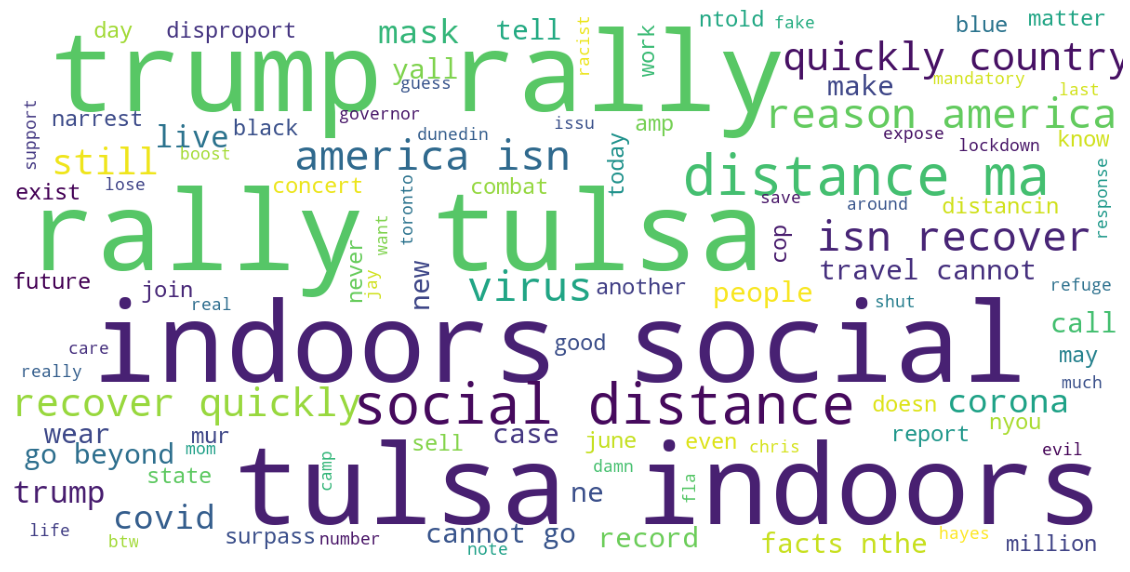

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 100,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data['cleaned_text'])

In [34]:
# Focus on 'compound' scores
# Create a new column called 'sentiment_class'
sentimentclass_list = []

for i in range(0, len(data)):
    
    # current 'compound' score:
    curr_compound = data.iloc[i,:]['compound']
    
    if (curr_compound <= 1.0 and curr_compound >= 0.55):
        sentimentclass_list.append(5)
    elif (curr_compound < 0.55 and curr_compound >= 0.10):
        sentimentclass_list.append(4)
    elif (curr_compound < 0.10 and curr_compound > -0.10):
        sentimentclass_list.append(3)
    elif (curr_compound <= -0.10 and curr_compound > -0.55):
        sentimentclass_list.append(2)
    elif (curr_compound <= -0.55 and curr_compound >= -1.00):
        sentimentclass_list.append(1)

# Add the new column 'sentiment_class' to the dataframe
data['sentiment_class'] = sentimentclass_list

# Check out the new column
data.tail()['sentiment_class']

26495    3
26496    4
26497    4
26498    3
26499    4
Name: sentiment_class, dtype: int64

In [35]:

# Verify if the classification assignment is correct:
data.iloc[0:5, :][['compound', 'sentiment_class']]

,compound,sentiment_class
0,-0.7430,1
1,0.7079,5
2,0.0258,3
3,-0.7430,1
4,-0.7430,1


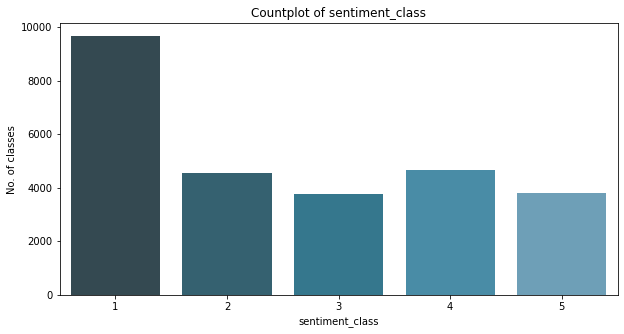

In [36]:

import seaborn as sns

# Distribution of sentiment_class
plt.figure(figsize = (10,5))
sns.set_palette('PuBuGn_d')
sns.countplot(data['sentiment_class'])
plt.title('Countplot of sentiment_class')
plt.xlabel('sentiment_class')
plt.ylabel('No. of classes')
plt.show()

In [39]:
# Display full text:
pd.set_option('display.max_colwidth', -1)

# Look at some examples of negative, neutral and positive tweets

# Filter 10 negative original tweets:
print("10 random negative original tweets and their sentiment classes:")
data[(data['sentiment_class'] == 1) | (data['sentiment_class'] == 2)].sample(n=10)[['text', 'sentiment_class']]

10 random negative original tweets and their sentiment classes:


,text,sentiment_class
17889,"A cluster of mysterious deaths, some involving infants and children, is under scrutiny amid questions of whether the novel coronavirus lurked in California months before it was first detected. https://t.co/nYZ8ayT9fx",2
3149,"“Because of the Chinese virus what happened about 3 months ago—it looked like we were in big trouble, and we were and I got it back together.” Trump at Tulsa rally. American media most upset with term 'Chinese virus', calling DT a racist. Also shows the disconnect b/w media &amp; ppl",1
8209,@FennerMichelle @JDJones35748029 @weijia Kung flu is not at race i am tired of you libs trying to make nothing in to some thing did you say anything when msm called it the chinese virus or the wuhan virus i bet you did not,2
10977,"Kentucky has used Covid-19 as an excuse to slash polling places for Tuesday’s vital primary to defeat #MitchMcConnell. There were 3500+. Now, there are 200. \n\nJefferson County, where half the Black voters are, will have 1 polling place for 610,000+ voters.\nhttps://t.co/mTJT1dSVP9",2
22534,"As COVID-19 spread across the globe, many U.S. workers were hurt through no fault of their own.\n\nAs America recovers, President @realDonaldTrump won't allow blue-collar and middle-class workers to stay on the sidelines and be replaced by new foreign labor. https://t.co/A68ueVC88u https://t.co/tFRwGZE9jX",1
25081,DMV Ain’t Gone Like It Till One Of These Promoters Or IG Models Die From COVID 19 Then Niggas Gone Wanna Stay Home,2
1069,"Trump's rally in Tulsa is indoors, with no social distancing and no mask requirements—all in violation of CDC guidelines. Trump is willing to spread the COVID-19 virus in order to hear some cheers. He is a direct threat to the health of the American people. He must be defeated.",1
5851,Why did the Washington Post all of a sudden remove the daily China Virus death tracker from its front page now that COVID deaths are decreasing nationwide?\n\nI guess it just doesn’t fit their narrative anymore.\n\n🤔,1
21550,India will overtake China; survive COVID-19 crisis: BJP MP Subramanian Swamy https://t.co/v0oHmrSWkU via @NewIndianXpress,1
19984,"Florida is a COVID-19 apocalypse compliments of science-denier, idiot, and @realDonaldTrump sycophant, @GovRonDeSantis. Nearly every day in June has set a new daily record. Perhaps opening the restaurants, bars and beaches weeks ago was a horrible idea.",1


In [40]:

# Filter 10 neutral original tweets:
print("10 random neutral original tweets and their sentiment classes:")
data[(data['sentiment_class'] == 3)].sample(n=10)[['text', 'sentiment_class']]

10 random neutral original tweets and their sentiment classes:


,text,sentiment_class
6297,"#Zartajgul Correction: CO' stands for corona, 'VI' for virus, and 'D' for disease. Formerly, this disease was referred to as '2019 novel coronavirus' or '2019-nCoV.' The COVID-19 virus is a new virus linked to the same family of viruses as Severe Acute Respiratory Syndrome.",3
9769,Covid china virus\n@XiJingpingReal\n@globaltimesnews\n@PDChina\n@PMOIndia\n#IndiaChinaFaceOff \n#IndiaWithArmyAndPmModi https://t.co/XQxPQ3sxc6,3
13578,@ProjectLincoln Arizona highest current Covid 19 hot spot so naturally that is where Trump will hold next rally.,3
23012,"""Arizona hits new COVID-19 hospitalization records as cases continue to spike ahead of president's visit ""\nhttps://t.co/nmyhGXiGYu",3
22699,"BREAKING: Florida surpassed 100,000 reported COVID-19 cases overnight",3
26158,"No evidence of Covid 19 case growth after #BlackLivesMatter protests. 🤔\n\n“Anonymous” cell phone tracking data, pulled from 315 U.S. cities (281 of which saw protests) was used to determine increase within 21+ days after onset of protests \n\nhttps://t.co/uTdgwa4Yb2",3
23270,#BREAKING: Two new cases of COVID-19 in New Zealand https://t.co/bX4xfqmVcx https://t.co/vGo1ILZsNG,3
12398,"A global battery firm is going out of business, citing Covid-19 https://t.co/MRnBxbSORH",3
2466,"@brhodes But, but Trump said the virus was almost all gone. Did anyone tell the MLB? \n\nhttps://t.co/dYQmpkcc7u",3
5143,@JakeWebber9 do you have the corona virus in your butt,3


In [44]:

# Filter 20 positive original tweets:
print("20 random positive original tweets and their sentiment classes:")
data[(data['sentiment_class'] == 4) | (data['sentiment_class'] == 5)].sample(n=20)[['text', 'sentiment_class']]

20 random positive original tweets and their sentiment classes:


,text,sentiment_class
20857,"Jubilee MPs to be sane avoid KICC meeting like Covid-19 it has mutated to a party of intimidation,blackmail &amp;\nInsults contrary to its vision , attend thro Zoom like the party leader @Tuko_co_ke @TheStarKenya @citizentvkenya @ntvkenya @KTNNewsKE @StateHouseKenya",5
12331,"NYC friends: My neighbor passed away due to covid-19 &amp; his two cats are in need of a new, loving home. Suzi (f, 11) &amp; Sammy (m, 8) are healthy, adorable kitties. It would be ideal for them to be adopted together. Please let me know if you're interested, or spread the word https://t.co/rsjTdaU6uX",5
4121,6 members of Trump's Tulsa advance staff have tested positive for COVID-19. Each may have infected hundreds with the virus already.,5
24991,The reason why America isn’t recovering from COVID-19 as quickly as other countries is because we are a country that values individualism over collectivism. Nobody here wants to do anything that is a minor inconvenience to them in order to protect their neighbors.,4
11377,is this rally are for a new covid-19 outbreak? asking it for s friend https://t.co/Pmsu1Nzcbu,4
11943,WHO welcomes preliminary results about dexamethasone use in treating critically ill COVID-19 patients https://t.co/tyPI4zmyI2,4
8582,"Trump bragging about how we were in trouble three months ago because of “the Chinese virus” but that he got it back together by calling Russia and Saudi Arabia and Mexico, and that he saved 10 million jobs.",4
15249,"IF ITS SUNDAY: Despite a rise in COVID-19 cases, acting DHS Secretary Chad Wolf tells @chucktodd “we are doing a great job” at “trying to get this economy … country back up and running.” #MTP https://t.co/brR4QS9APW",5
17859,I’m tired of all the righteous moralising over COVID-19. Everybody has done something or supported something that has gone against the rules and has helped undermine social distancing. #COVID19Vic,4
25841,The reason why America isn’t recovering from COVID-19 as quickly as other countries is because we are a country that values individualism over collectivism. Nobody here wants to do anything that is a minor inconvenience to them in order to protect their neighbors.,4


In [45]:

# the column data['hashtags'] returns a list of string(s) for each tweet.
# Build a list of all hashtags in the dataset

hashtag_list = []

for i in range(0, len(data)):
    # Obtain the current list of hashtags
    curr_hashtag = data.iloc[i, :]['hashtags']
    
    # Extract and append the hashtags to 'hashtag_list':
    for j in range(0, len(curr_hashtag)):
        hashtag_list.append(curr_hashtag[j])
    
# Print out the list
print(hashtag_list)

['[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', ']', '[', '{', "'", 't', 'e', 'x', 't', "'", ':', ' ', "'", 'g', 'o', 'l', 'f', "'", ',', ' ', "'", 'i', 'n', 'd', 'i', 'c', 'e', 's', "'", ':', ' ', '[', '1', '9', '1', ',', ' ', '1', '9', '6', ']', '}', ',', ' ', '{', "'", 't', 'e', 'x', 't', "'", ':', ' ', "'", 'J', 'a', 'y', 'J', 'B', 'm', 'e', 'd', 'i', 'a', "'", ',', ' ', "'", 'i', 'n', 'd', 'i', 'c', 'e', 's', "'", ':', ' ', '[', '1', '9', '7', ',', ' ', '2', '0', '8', ']',

In [46]:
# No. of hashtags
print('No. of hashtags used in {} tweets is {}'.format(len(data), len(hashtag_list)))

No. of hashtags used in 26436 tweets is 319908


In [47]:
# Now we have the list of hashtags, we can convert this into a simple DataFrame, which will be used for visualization.
df_hashtag = pd.DataFrame(
    {'hashtags': hashtag_list}
)

print(df_hashtag.head())
print('Shape of df_hashtag is:', df_hashtag.shape)

  hashtags
0  [      
1  ]      
2  [      
3  ]      
4  [      
Shape of df_hashtag is: (319908, 1)
